In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

## Preparation of the dataset

Drop all categorical columns and the rating columns, since we want to compare the clustering results with the rating.

In [3]:
df = pd.read_csv("../results/train_clean.csv", index_col=0)

In [4]:
df['countryOfOrigin'] = df['countryOfOrigin'].apply(ast.literal_eval)
df['genres'] = df['genres'].apply(ast.literal_eval)

In [5]:
df['genres'][0][0]

'Action'

In [ ]:
df = df[df['runtimeMinutes'] <= 187.5]

### Countries of Origin

We keep only the 4 most frequent countries of origin.

In [7]:
mbl = MultiLabelBinarizer()
countries_df = pd.DataFrame(mbl.fit_transform(df['countryOfOrigin']), columns=mbl.classes_, index=df.index)
countries_df = countries_df.astype('bool')
most_fr_countries = countries_df.sum().sort_values(ascending=False)
most_fr_countries.head(10)

US    7100
GB    1763
JP     844
FR     820
CA     618
IN     613
DE     501
IT     414
ES     322
AU     312
dtype: int64

In [8]:
countries_df = countries_df[most_fr_countries.head(4).index]
countries_df.head()

,US,GB,JP,FR
0,True,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


### Genres

We keep all genres.

In [9]:
genres_df = pd.DataFrame(mbl.fit_transform(df['genres']), columns=mbl.classes_, index=df.index)
genres_df = genres_df.astype('bool')
genres_df.sum().sort_values(ascending=False)

Drama          6131
Comedy         4836
Short          2464
Action         1947
Documentary    1821
Crime          1729
Adventure      1597
Animation      1487
Romance        1378
Family         1224
Thriller        783
Horror          688
Fantasy         651
Mystery         641
Music           549
Sci-Fi          449
Adult           427
Reality-TV      365
History         348
Talk-Show       337
Western         301
Biography       271
Game-Show       250
Musical         228
Sport           227
War             208
News            156
Film-Noir        27
dtype: int64

### Numeric columns

We drop the rating for the clustering

In [10]:
numeric_cols = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index
numeric_df = df[numeric_cols]
numeric_df.drop(['ratingNum'], axis=1, inplace=True)
numeric_df.head()

/tmp/ipykernel_9848/1867124789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df.drop(['ratingNum'], axis=1, inplace=True)


,startYear,runtimeMinutes,numVotes,totalImages,totalCredits,numRegions,numGenres,criticReviewsRatio
0,1995,40.0,6.659294,0.693147,3.091042,0.693147,3,1.000000
1,1982,28.0,2.484907,0.693147,0.693147,0.693147,1,0.000000
2,1992,90.0,3.663562,0.693147,3.218876,0.693147,1,0.000000
3,2021,31.0,2.772589,3.135494,4.043051,0.693147,1,0.000000
4,2020,80.0,9.662625,5.852202,3.871201,3.496508,3,0.008772


### TitleType

In [11]:
title_df = pd.get_dummies(df['titleType'], columns=['titleType'], drop_first=True)
title_df.head()

,short,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvShort,tvSpecial,video,videoGame
0,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False


### Boolean columns

In [12]:
bool_cols = df.dtypes[df.dtypes == 'bool'].index
bool_df = df[bool_cols]
bool_df.head()

,canHaveEpisodes,awardsAndNominations,hasVideos,moreCountriesOfOrigin
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,True,False,False,False
4,True,True,True,False


## Precompute distance matrix

We need to precompute a distance matrix in order to use also categorical variables.
We compute a distance matrix from the numeric columns using the euclidean distance after normalizing the features. We compute matrices for countries of origin, genres, title type and the original boolean columns using the jaccard distance.
We will obtain a final distance matrix summing the distances from all the matrices.

In [13]:
scaler = StandardScaler()
numeric_df = scaler.fit_transform(numeric_df)

In [14]:
distance_matrix = pdist(numeric_df, metric='euclidean')
del numeric_df
distance_matrix += pdist(bool_df, metric='jaccard')
del bool_df
distance_matrix += pdist(countries_df, metric='jaccard')
del countries_df
distance_matrix += pdist(genres_df, metric='jaccard')
del genres_df
distance_matrix += pdist(title_df, metric='jaccard')
del title_df

In [15]:
distance_matrix = squareform(distance_matrix)

In [16]:
distance_matrix.shape

(16335, 16335)

## Clustering

In [17]:
def get_linkage_matrix(model):
    # Create linkage matrix

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

With the distance matrix given by the euclidean distance of numeric features and the jaccard distance of `canHaveEpisodes`, `awardsAndNominations`, `hasVideos` and `moreCountriesOfOrigin`, the best results are obtained with complete linkage.

In [18]:
hier_single = AgglomerativeClustering(distance_threshold=0,
                                      n_clusters=None,
                                      metric='precomputed',
                                      linkage='single')
hier_single.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='single',
                        metric='precomputed', n_clusters=None)

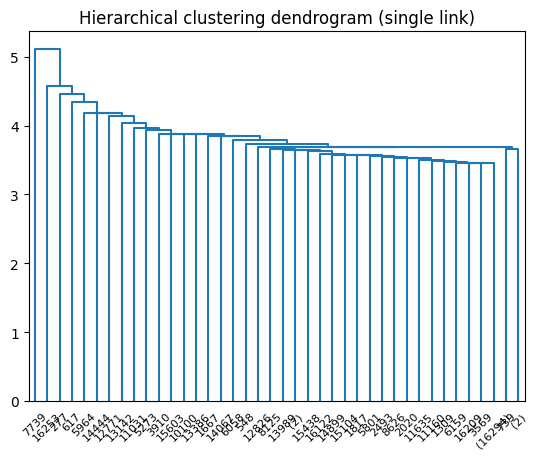

In [19]:
plt.title("Hierarchical clustering dendrogram (single link)")
plot_dendrogram(hier_single, truncate_mode="lastp", p=40,  color_threshold=0)
plt.show()

In [20]:
hier_average = AgglomerativeClustering(distance_threshold=0,
                                       n_clusters=None,
                                       metric='precomputed',
                                       linkage='average')
hier_average.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        metric='precomputed', n_clusters=None)

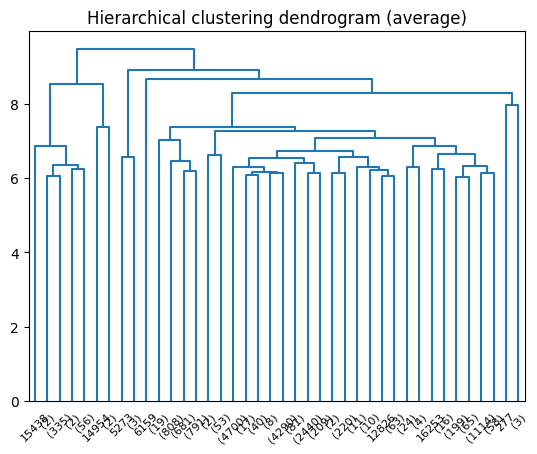

In [21]:
threshold = 5

plt.title("Hierarchical clustering dendrogram (average)")
plot_dendrogram(hier_average, truncate_mode="lastp", p=40,  color_threshold=threshold)
plt.show()

In [22]:
Z = get_linkage_matrix(hier_average)
labels = fcluster(Z, t=threshold, criterion='distance')
silhouette_score(distance_matrix, labels, metric='precomputed')

np.float64(0.082722794393883)

In [23]:
np.unique(labels, return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141], dtype=int32),
 array([   2,    3,  321,    2,    9,    2,    2,    2,   52,    1,    1,
           1,    1,    3,    1,    5,   14,  420,    1,  155,   23,  209,
          30,   26,    7,  216,    2,  159, 

Average linkage returns a very big cluster and several really small clusters.

In [24]:
df['c_average'] = labels

In [25]:
hier_complete = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                metric='precomputed',
                                linkage='complete')
hier_complete.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='precomputed', n_clusters=None)

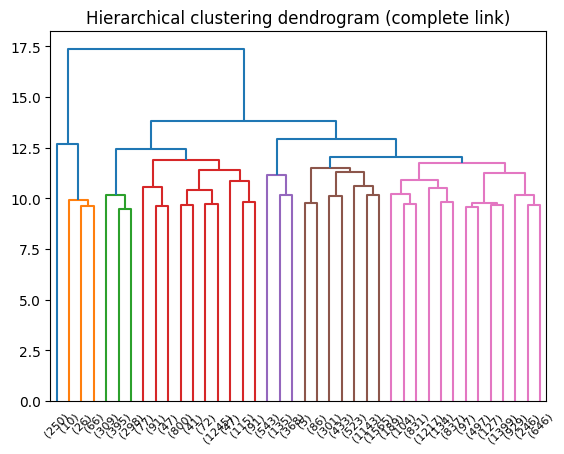

In [38]:
threshold = 12

plt.title("Hierarchical clustering dendrogram (complete link)")
plot_dendrogram(hier_complete, truncate_mode="lastp", p=40,  color_threshold=threshold)
plt.show()

In [39]:
Z = get_linkage_matrix(hier_complete)
labels = fcluster(Z, t=threshold, criterion='distance')
silhouette_score(distance_matrix, labels, metric='precomputed')

np.float64(0.05965464215550415)

In [40]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 250,  102, 1002, 2626, 1046, 4056, 7253]))

In [41]:
df['c_complete'] = labels

Text(0.5, 1.0, 'Clusters (average) against title type')

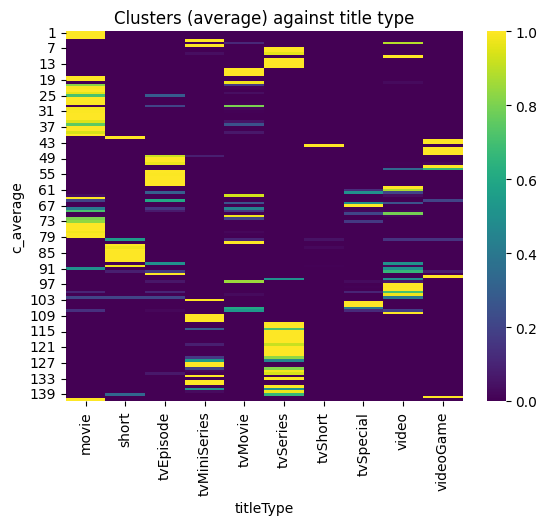

In [42]:
sns.heatmap(pd.crosstab(df['c_average'], df['titleType'],
                        normalize='index'),
                        cmap='viridis')
plt.title("Clusters (average) against title type")

Text(0.5, 1.0, 'Clusters (complete link) against title type')

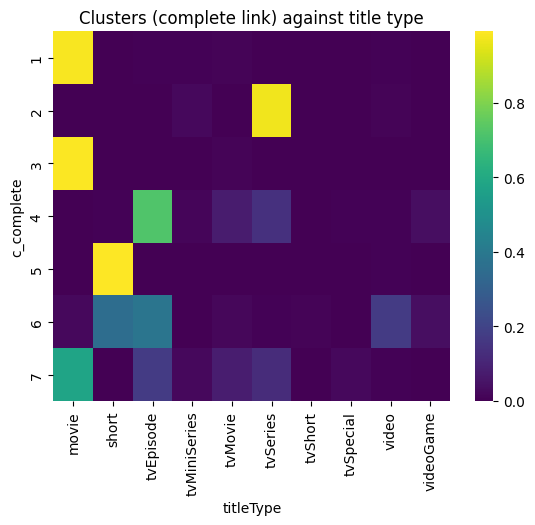

In [43]:
sns.heatmap(pd.crosstab(df['c_complete'], df['titleType'],
                        normalize='index'),
                        cmap='viridis'
                        )
plt.title("Clusters (complete link) against title type")

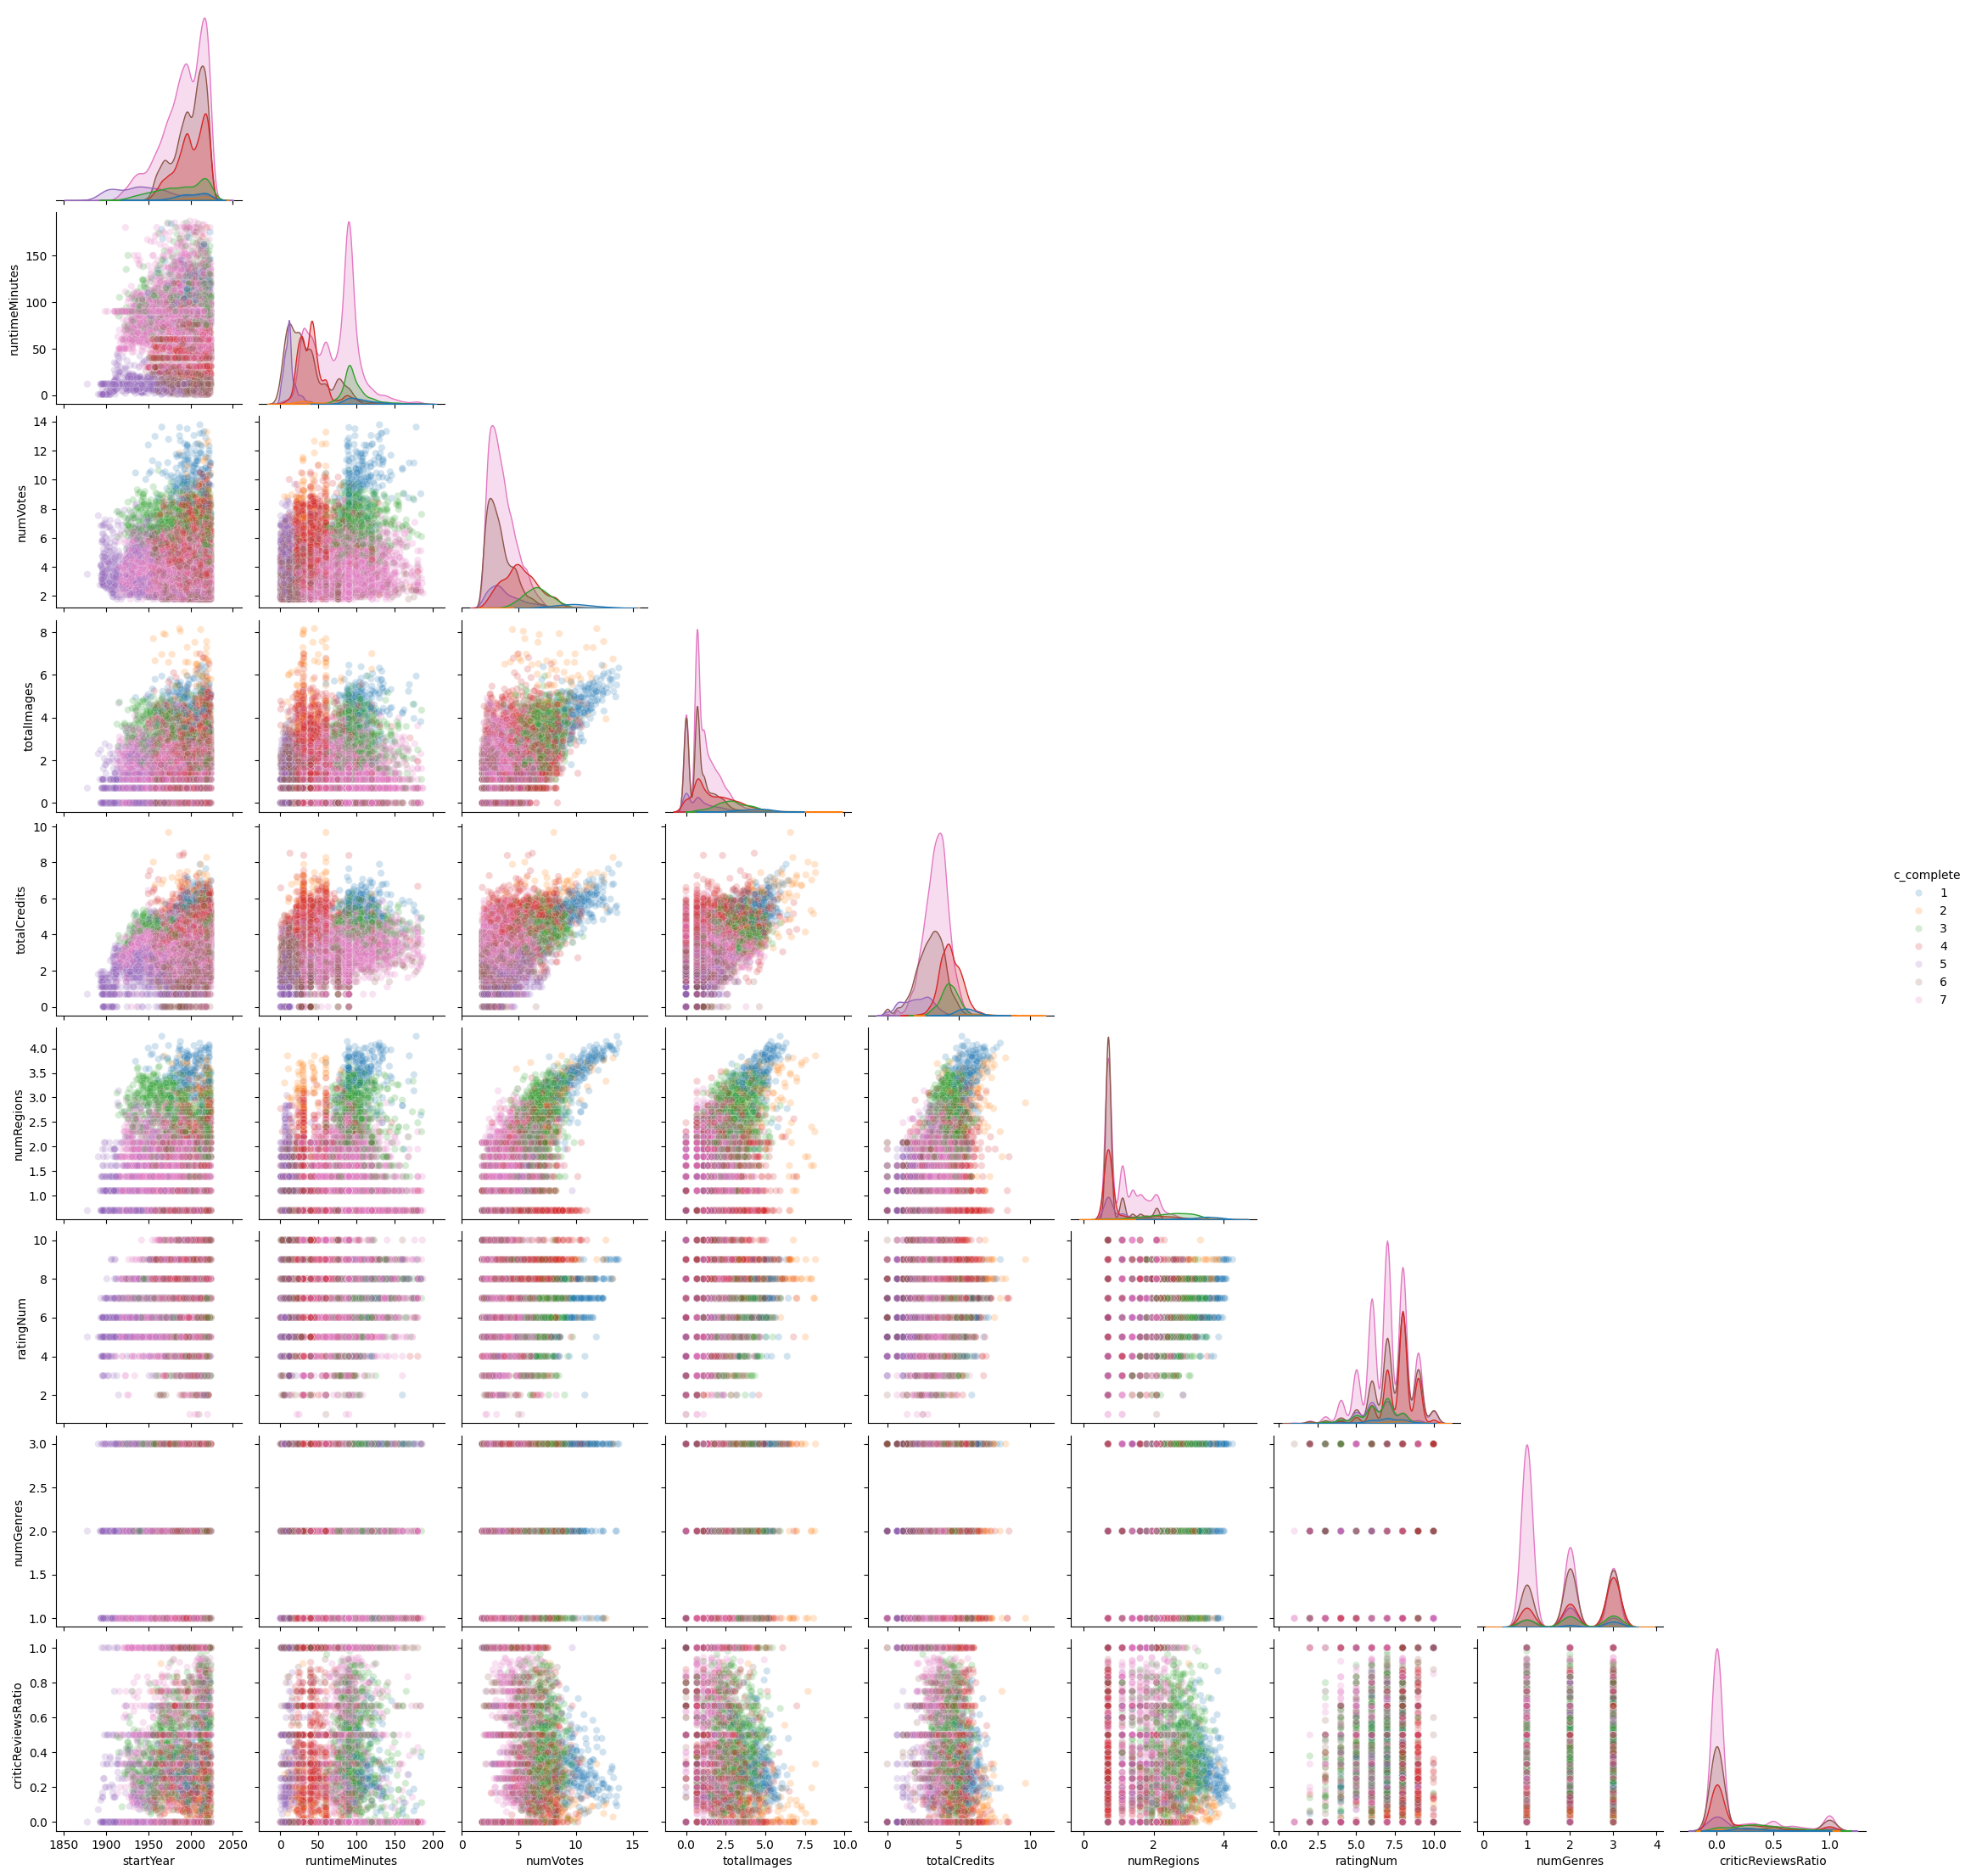

In [44]:
df['c_complete'] = pd.Categorical(df['c_complete'])
sns.pairplot(df[list(numeric_cols) + ['c_complete']], hue='c_complete', corner=True, plot_kws={'alpha':.2})

<Axes: xlabel='startYear', ylabel='runtimeMinutes'>

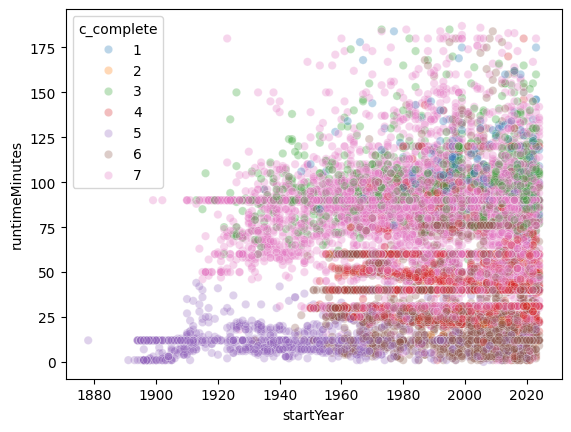

In [45]:
sns.scatterplot(df, x='startYear', y="runtimeMinutes", hue='c_complete', alpha=.3)

Here we can clearly see that the hierarchical clustering detected two clusters of shorts, that differ for date of release: cluster 3 contains older shorts, while cluster 4 contains shorts that were realeased from the 60s onwards. I we had selected a higher threshold for splitting the dendrogram, these two clusters would be merged together.
We can also see that cluster 7 (which is the more numerous), containing mainly movies and tv episodes is somewhat cleanly separated from the two shorts clusters by means of runtime.

<Axes: xlabel='runtimeMinutes', ylabel='numVotes'>

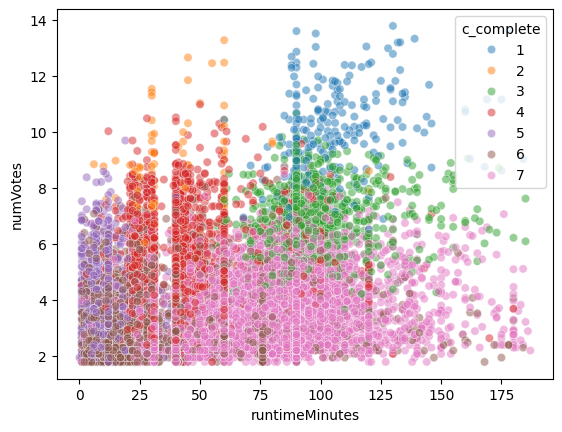

In [46]:
sns.scatterplot(df, x='runtimeMinutes', y='numVotes', hue='c_complete', alpha=.5)

Here we can see that clusters 1 and 2, that contain maily movies and some TV series, were splitted with respect to the number of votes they received.
Both clusters contain records that are on average more popular than all other records in the dataset, but the ones clustered in cluster 2 were the most popular. Cluster 2 contains blockbusters like "Harry Potter and the Deathly Hallows - Part 2", "Il buono, il brutto, il cattivo" and "Full metal jacket", just to name a few, as well as very popular TV series like "The Witcher" and "Euphoria".

In [47]:
df[df['c_complete'] == '2'].sort_values('numVotes', ascending=False).head(20)

,originalTitle,rating,startYear,runtimeMinutes,numVotes,totalImages,totalCredits,titleType,canHaveEpisodes,numRegions,countryOfOrigin,genres,ratingNum,numGenres,criticReviewsRatio,awardsAndNominations,hasVideos,moreCountriesOfOrigin,c_average,c_complete


In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', metric='precomputed')
reduced_df = pd.DataFrame(tsne.fit_transform(distance_matrix))

<Axes: xlabel='0', ylabel='1'>

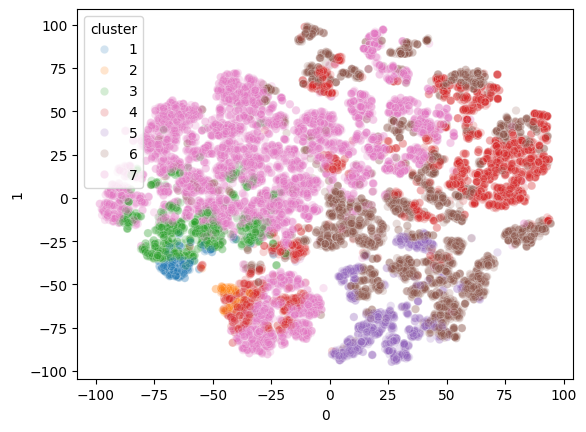

In [49]:
reduced_df['cluster'] = labels
sns.scatterplot(reduced_df, x=0, y=1, hue='cluster', palette='tab10', alpha=.2)